In [1]:
import os
import pandas as pd
import numpy as np
import h5py
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
emme_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','emme_configuration.toml'))
network_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','network_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.1%}".format

## VMT

In [2]:
df = pd.read_csv(os.path.join(valid_config['model_dir'], r'outputs/network/county_network.csv'))
df.index = df.county_name
df.loc['Total',:] = df.sum().values
df = df[['VMT','VHT','delay']]
df

,VMT,VHT,delay
county_name,,,
King,"43,367,957","1,371,588","155,379"
Kitsap,"4,296,499","125,990","2,274"
Outside Region,"332,433","6,407",2
Pierce,"18,485,584","552,025","31,743"
Snohomish,"16,179,615","473,876","31,710"
Total,"82,662,089","2,529,886","221,108"


In [3]:
df = pd.read_csv(os.path.join(valid_config['model_dir'], r'outputs/network/county_network.csv'))

df_obs = pd.read_sql("SELECT * FROM observed_vmt WHERE year="+str(input_config['base_year']), con=conn)
df_obs.rename(columns={'vmt': 'observed'}, inplace=True)

df = df[['county_name','VMT']].merge(df_obs, left_on='county_name', right_on='county')
df.rename(columns={'VMT': 'model'}, inplace=True)
df.index = df['county']
df[['observed','model']] = df[['observed','model']].astype('float')

df.loc['Total',:] = df.sum().values

df['% diff'] = (df['model']-df['observed'])/df['observed']
df[['% diff']] = df[['% diff']].applymap(format_percent)
df[['model','observed','% diff']]

C:\Users\modeller\AppData\Local\Temp\ipykernel_14240\2489709904.py:14: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,model,observed,% diff
county,,,
King,"43,367,957","43,820,112",-1.0%
Kitsap,"4,296,499","4,840,030",-11.2%
Pierce,"18,485,584","17,994,803",2.7%
Snohomish,"16,179,615","15,825,794",2.2%
Total,"82,329,656","82,480,739",-0.2%


## Daily Traffic Counts

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_volume.csv'))
df[['modeled', 'observed']] = df[['modeled', 'observed']].astype('float')
_df = df.groupby('@facilitytype').sum()[['observed', 'modeled']]
_df.loc['Total', :] = _df.sum().values
_df['diff'] = _df['modeled'] - _df['observed']
_df['percent_diff'] = _df['diff'] / _df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

C:\Users\modeller\AppData\Local\Temp\ipykernel_14240\3988584661.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,observed,modeled,diff,percent_diff
@facilitytype,,,,
Arterial,"13,059,811","13,049,777","-10,034",-0.1%
Collector,"72,096","73,359","1,263",1.8%
Freeway,"46,324,090","45,141,378","-1,182,712",-2.6%
HOV,"246,054","281,929","35,875",14.6%
Ramp,"334,132","262,424","-71,708",-21.5%
Total,"60,036,183","58,808,867","-1,227,316",-2.0%


In [5]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume_county_facility.csv'))
df[['modeled','observed']] = df[['modeled','observed']].astype('float')

_df = df.groupby('county').sum()[['observed','modeled']]
_df.loc['Total',:] = _df.sum().values
_df['diff'] = _df['modeled']-_df['observed']
_df['percent_diff'] = _df['diff']/_df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

C:\Users\modeller\AppData\Local\Temp\ipykernel_14240\4255960492.py:8: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,observed,modeled,diff,percent_diff
county,,,,
King,"32,134,196","32,230,061","95,865",0.3%
Kitsap,"3,636,120","2,822,937","-813,183",-22.4%
Pierce,"12,442,361","12,619,580","177,219",1.4%
Snohomish,"11,823,506","11,136,289","-687,217",-5.8%
Total,"60,036,183","58,808,867","-1,227,316",-2.0%


## Daily Traffic Scatterplot

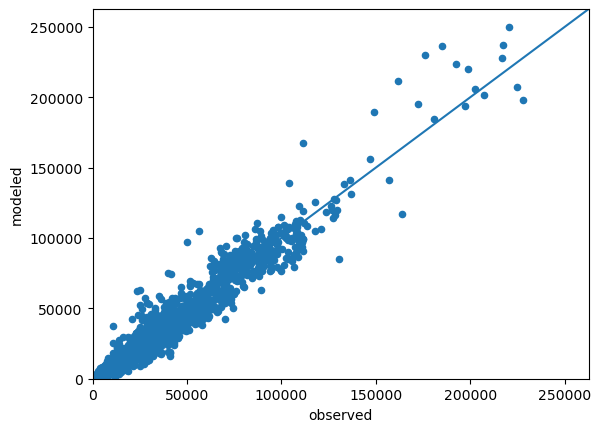

In [6]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

In [7]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

r^2: 0.9660066246549027


King r^2: 0.9663519761803304
Kitsap r^2: 0.9637737712240951
Pierce r^2: 0.9668256621944221
Snohomish r^2: 0.9625631734926484


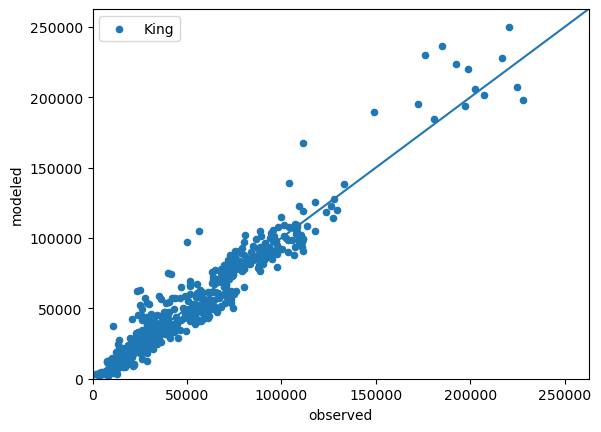

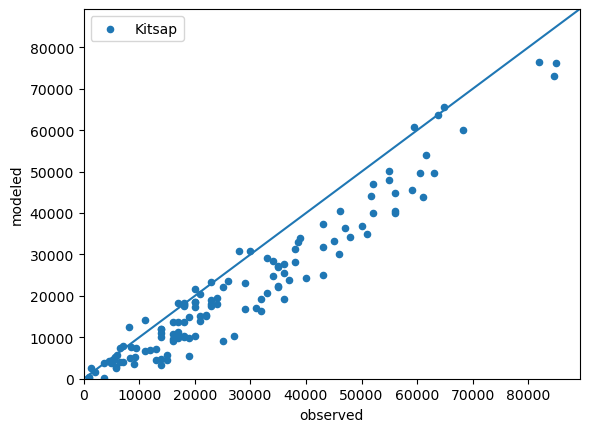

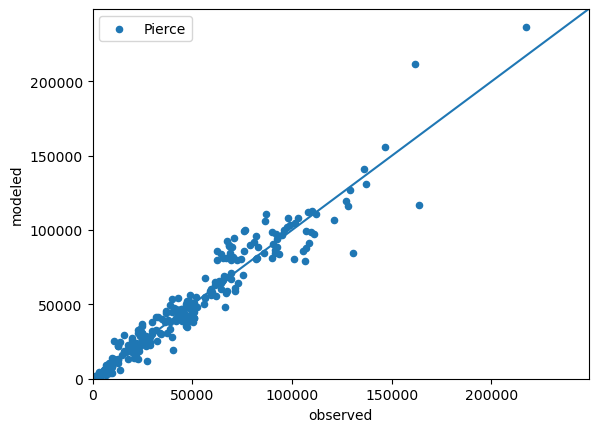

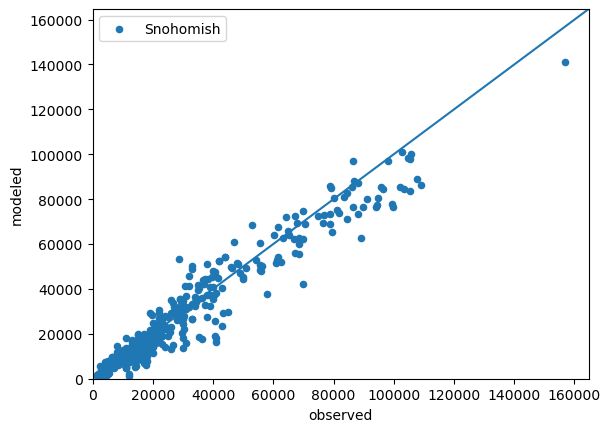

In [8]:
for county in np.unique(df['county']):
    _df = df[df['county'] == county]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=county)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    print(str(county) + ' r^2: ' + str(r_value))

In [9]:
df['@facilitytype'].unique()

array(['Freeway', 'Ramp', 'HOV', 'Arterial', 'Collector'], dtype=object)

r^2 Freeway: 0.9568246989523925


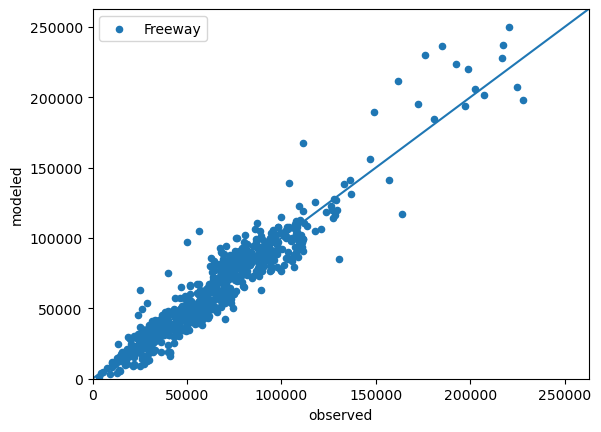

In [10]:
# for factype in ['Freeway','Arterial']:
for factype in ['Freeway']:
    _df = df[df['@facilitytype'] == factype]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=factype)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    print('r^2 ' + str(factype) + ': ' + str(r_value))

In [11]:
## hourly volumnes

In [12]:
# df = pd.read_csv(os.path.join(csv_path,'hourly_volume.csv'))
# ax = df.plot(kind='scatter', x='observed', y='modeled')
# lim = df[['observed','modeled']].max().max()*1.05
# ax.set_ylim(0,lim)
# ax.set_xlim(0,lim)
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x)
# slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
# print('r^2: ' + str(r_value))

## Screenlines

In [13]:
df = pd.read_csv(os.path.join(csv_path,'screenlines.csv'))
df.loc[df.index.max() + 1]= df.sum(numeric_only=True)
#df = df.append(df.sum(numeric_only=True), ignore_index=True)
df.at[df.index[-1], 'name'] = 'TOTAL'
#df.at['C', 'name'] = 10
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

C:\Users\modeller\AppData\Local\Temp\ipykernel_14240\2463447694.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,name,observed,modeled,county,diff,percent_diff
0,AUBURN - SOUTH KING,"592,476","518,462",King,"-74,014",-12.5%
1,KENT,"559,335","489,463",King,"-69,872",-12.5%
2,SHIP CANAL,"481,563","496,238",King,"14,675",3.0%
3,SEATTLE - SOUTH OF CBD,"473,322","462,750",King,"-10,572",-2.2%
4,MILL CREEK,"391,447","369,068",King,"-22,379",-5.7%
5,SOUTH BELLEVUE,"389,700","363,476",King,"-26,224",-6.7%
6,KIRKLAND-REDMOND,"380,783","382,453",King,"1,670",0.4%
7,SEATTLE - NORTH,"356,051","344,614",King,"-11,437",-3.2%
8,TACOMA - EAST OF CBD,"324,463","337,921",Pierce,"13,458",4.1%
9,PARKLAND,"299,722","269,496",Pierce,"-30,226",-10.1%


r^2 : 0.9907552897597844


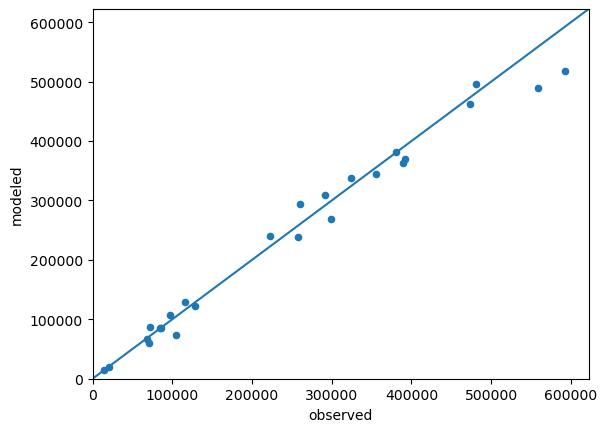

In [14]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))

# External Stations

In [15]:
df = pd.read_csv(os.path.join(csv_path,'external_volumes.csv'))
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

C:\Users\modeller\AppData\Local\Temp\ipykernel_14240\2144700014.py:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,external_station,location,county,observed,modeled,diff,percent_diff
0,3733,I-5 to Olympia,Pierce,"129,250","131,022","1,772",1.4%
1,3744,I-5 to Mount Vernon,Snohomish,"65,880","64,124","-1,756",-2.7%
2,3739,I-90 @ Snoqualmie Pass,King,"30,500","33,275","2,775",9.1%
3,3734,SR-507 to Yelm,Pierce,"22,700","22,727",27,0.1%
4,3746,SR-532 to Camano Island,Snohomish,"21,250","20,766",-484,-2.3%
5,3749,SR-3 to Belfair,Kitsap,"20,329","18,154","-2,175",-10.7%
6,3748,Hood Canal Bridge,Kitsap,"18,200","17,836",-364,-2.0%
7,3747,Mukilteo-Clinton Ferry,Snohomish,"9,800","5,965","-3,835",-39.1%
8,3745,SR-530 N/O Stanwood,Snohomish,"9,100","9,168",68,0.8%
9,3750,SR-302 to Shelton,Pierce,"4,550","4,560",10,0.2%


r^2 : 0.9990066604550166


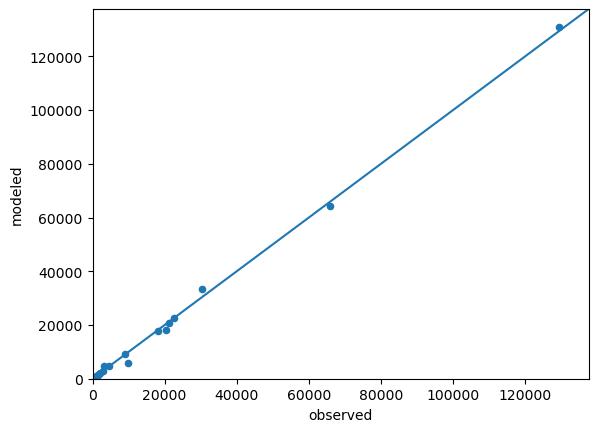

In [16]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))

In [17]:
## External trips/VMT
df_23 = h5py.File(r'..\..\..\..\inputs\model\daysim\roster\7to8.h5')
df_23_skims_sov = df_23['Skims']['sov_inc2d'][:]/100
df_23_skims_hov2 = df_23['Skims']['hov2_inc2d'][:]/100
df_23_skims_hov3 = df_23['Skims']['hov3_inc2d'][:]/100

df_results_new = pd.DataFrame()

tod_list = ['5to6', '6to7', '7to8', '8to9', '9to10', '10to14', '14to15', '15to16', '16to17', '17to18', '18to20', '20to5']
for tod in tod_list:
#     print(tod)
    df_temp = pd.DataFrame()
    for mode in ['sov','hov2','hov3']:
#         print(mode)
        od_new = h5py.File(r'..\..\..\..\outputs\supplemental\external_work_'+tod+'.h5', 'r')[mode][:]
        df_temp.loc[tod,mode+'_vmt'] = (df_23_skims_sov*od_new).sum()
        df_temp.loc[tod,mode+'_trips'] = od_new.sum()
        df_temp.loc[tod,mode+'_avg_dist'] = df_temp.loc[tod,mode+'_vmt']/df_temp.loc[tod,mode+'_trips']
    df_results_new = pd.concat([df_results_new, df_temp ])

In [18]:
df_vmt = pd.DataFrame(df_results_new[['sov_vmt','hov2_vmt','hov3_vmt']].sum(),
            columns=['VMT'])
df_vmt.index = [i.split('_')[0].upper() for i in df_vmt.index]

df_trips = pd.DataFrame(df_results_new[['sov_trips','hov2_trips','hov3_trips']].sum(),
            columns=['Trips'])
df_trips.index = [i.split('_')[0].upper() for i in df_trips.index]

df = df_vmt.merge(df_trips, left_index=True, right_index=True)

df.loc['Total',:] = df.sum(axis=0)
df['Avg Distance'] = df['VMT']/df['Trips']
df

,VMT,Trips,Avg Distance
SOV,"7,565,134","237,921",32
HOV2,"574,773","18,304",31
HOV3,"211,883","6,392",33
Total,"8,351,790","262,617",32


# Trucks

In [19]:
daily_counts = pd.read_sql("SELECT * FROM daily_counts WHERE year="+str(input_config['base_year']), con=conn)

daily_counts['htrk_vehicles'] = daily_counts['htrk_vehicles'].astype('float').fillna(-1)

facility_type_lookup = {
    1: "Freeway",  # Interstate
    2: "Freeway",  # Ohter Freeway
    3: "Freeway",  # Expressway
    4: "Ramp",
    5: "Arterial",  # Principal arterial
    6: "Arterial",  # Minor Arterial
    7: "Collector",  # Major Collector
    8: "Collector",  # Minor Collector
    9: "Collector",  # Local
    10: "Busway",
    11: "Non-Motor",
    12: "Light Rail",
    13: "Commuter Rail",
    15: "Ferry",
    16: "Passenger Only Ferry",
    17: "Connector",  # centroid connector
    18: "Connector",  # facility connector
    19: "HOV",  # HOV Only Freeway
    20: "HOV",  # HOV Flag
}

In [20]:
# FIXME: move to validation.py
df_network = pd.read_csv(r"..\..\..\..\outputs\network\network_results.csv")
model_vol_df = df_network.copy()
model_vol_df["@facilitytype"] = model_vol_df["@facilitytype"].map(
    facility_type_lookup
)

# Get daily and model volumes
df_daily = (
    model_vol_df.groupby(["@countid"])
    .agg({"@tveh": "sum", "@facilitytype": "first", '@mveh': 'sum', '@hveh': 'sum'})
    .reset_index()
)

# Merge observed with model
df_daily = df_daily.merge(daily_counts, left_on="@countid", right_on="flag")

In [21]:
county_lookup = {
    33: 'King',
    35: 'Kitsap',
    53: 'Pierce',
    61: 'Snohomish'
}

df_daily['County'] = df_daily['countyid'].map(county_lookup)

In [22]:
df_daily_med = df_daily.copy()
df_daily_med.rename(columns={'@mveh': 'Model', 'mtrk_vehicles': 'Observed'}, inplace=True)
df_daily_med = df_daily_med[~df_daily_med['Observed'].isnull()]
for col in ['Model','Observed']:
    df_daily_med[col] = df_daily_med[col].astype('int')
df_daily_med = df_daily_med[df_daily_med['Observed'] > 0]

df_daily_heavy = df_daily.copy()
df_daily_heavy.rename(columns={'@hveh': 'Model', 'htrk_vehicles': 'Observed'}, inplace=True)
df_daily_heavy = df_daily_heavy[~df_daily_heavy['Observed'].isnull()]
for col in ['Model','Observed']:
    df_daily_heavy[col] = df_daily_heavy[col].astype('int')
df_daily_heavy = df_daily_heavy[df_daily_heavy['Observed'] > 0]

In [23]:
def create_truck_chart(df_daily, truck_type, county=None):

    if county:
        df_daily = df_daily[df_daily['County'] == county]
        title = truck_type + ' Trucks: '+county
    else:
        title = truck_type + ' Trucks: Region'

    slope, intercept, r_value, p_value, std_err = stats.linregress(df_daily['Observed'], df_daily['Model'])

    fig = px.scatter(df_daily, y='Model', x='Observed', title=title, hover_data=['location','County'])
    fig.update_layout(height=600, width=800, margin=dict(l=100, r=100, t=100, b=100))

    # Get max value, either observed or modeled
    max_val = df_daily[['Observed','Model']].max().max()

    # Add 45-degree line
    fig.add_shape(
        type="line",
        x0=0, y0=0,
        x1=max_val, y1=max_val,
        line=dict(color="Red", width=2, dash="dash")
    )

    # Add best fit line
    x_fit = np.linspace(0, max(df_daily['Observed']), 100)
    y_fit = slope * x_fit + intercept
    fig.add_trace(px.line(x=x_fit, y=y_fit, labels={'x':'Observed', 'y':'Model'}).data[0])
    fig.update_traces(line=dict(color="Grey", width=2))

    # Add label for 45-degree line

    fig.add_annotation(
        x=max_val*1.05,
        y=max_val*1.05,
        text='y = x',
        showarrow=False,
        font=dict(size=12, color="pink"),
        align="right"
    )

    # Add R-squared value as annotation
    fig.add_annotation(
        x=max(x_fit)*1.05,
        y=max(y_fit)*1.05,
        text=f'r^2 = {r_value**2:.2f}',
        showarrow=False,
        font=dict(size=12, color="black"),
        align="right"
    )

    return fig


### Heavy Truck Counts

In [24]:
fig = create_truck_chart(df_daily_heavy, 'Heavy')
fig.show()

In [25]:
fig = create_truck_chart(df_daily_heavy, 'Heavy', 'King')
fig.show()

In [26]:
fig = create_truck_chart(df_daily_heavy, 'Heavy', 'Kitsap')
fig.show()

In [27]:
fig = create_truck_chart(df_daily_heavy, 'Heavy', 'Pierce')
fig.show()

In [28]:
fig = create_truck_chart(df_daily_heavy, 'Heavy', 'Snohomish')
fig.show()

### Medium Truck Counts

In [29]:
fig = create_truck_chart(df_daily_med, 'Medium')
fig.show()

In [30]:
fig = create_truck_chart(df_daily_med, 'Medium', 'King')
fig.show()

In [31]:
fig = create_truck_chart(df_daily_med, 'Medium', 'Kitsap')
fig.show()

In [32]:
fig = create_truck_chart(df_daily_med, 'Medium', 'Pierce')
fig.show()

In [33]:
fig = create_truck_chart(df_daily_med, 'Medium', 'Snohomish')
fig.show()